In [347]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Background

The goal of this notebook is to create a finite difference method solver for the n-dimensional diffusion equation

$$
\frac{\partial}{\partial t} N(\vec{r}, t) = D \nabla^2 N(\vec{r}, t)
$$

where $\vec{r} = (x_1, \dots , x_n) \in \mathbb{R}^n$. This PDE will be solved on an n-dimensional rectangular prism $Q = [a_1, b_1] \times \dots \times [a_n, b_n] \subset \mathbb{R}^n$ over a time frame $[0, t_f]$. It will be solved with initial condition $N(\vec{r}, 0) = f(\vec{r}) \ (\forall \vec{r} \in Q)$ for some function $f: Q \rightarrow \mathbb{R}$, and with Dirichlet boundary conditions $N(\vec{r}, t) = 0 \ (\forall \vec{r} \in \partial Q, \ \forall t \in [0, t_f])$.

# 1-dimensional case

## Theory

To begin, we consider the 1-dimensional case of the diffusion equation 

$$
\frac{\partial}{\partial t} N(x, t) = D  \frac{\partial^2}{\partial x^2} N(x, t)
$$
.

This PDE will be solved on the interval $x \in [a, b]$ over a time frame $t \in [0, t_f]$. It will be solved with initial condition $N(x, 0) = f(x) \, \forall x \in [a, b]$ for some function f, and with Dirichlet boundary conditions $N(a, t) = N(b, t) = 0 \, \forall t \in [0, t_f]$.

In implementing a finite difference method solver for the equation $\frac{\partial}{\partial t} N(x, t) = D  \frac{\partial^2}{\partial x^2} N(x, t)$, we discretize time and space into steps of $\Delta t$ and $\Delta x$, respectively. Then using appropirate approximations for partial derivatives, we find

$$
\frac{N_i^{j+1} - N_i^{j}}{\Delta t} = \frac{D}{\Delta x^2} (N_{i+1}^j - 2 N_{i}^j + N_{i-1}^j)
$$

where upper indices represent time and lower indices represent spatial position. We can rearrange to find

$$
N_i^{j+1} = \frac{D \Delta t}{\Delta x^2} (N_{i+1}^j - 2 N_{i}^j + N_{i-1}^j) + N_i^j
$$

, which allows us to find N at the next time step from information about the current time.

Note: in solving the 1-dimensional diffusion equation, we must use a spatial resolution $\Delta x << \lambda$, where $\lambda$ is the characteristic wavelength of the initial condition function $f$. We must also use a time step $\Delta t << \frac{\Delta x^2}{D}$ in order to get accurate results. (These conditions were derived in Lecture 11.)

## Solver code

In [29]:
def solve_diffusion_eqn_1D(tspan, n_tsteps, xspan, n_xsteps, D, f, BC='dirichlet'):
    """
    Gives a numerical solution to the one-dimensional diffusion equation.
    Should have dx << lambda and dt << (dx)^2 / D for accurate results, where lambda is the characteristic
        wavelength of the initial condition function.
    tspan: [start_time, stop_time]
    n_tsteps: number of time steps to use
    xspan: [left_boundary, right_boundary]
    n_xsteps: number of spatial steps to use
    D: diffusion constant
    f: function f giving the initial condition N(x, 0) = f(x)
    BC: indicates boundary conditions to use. If 'dirichlet', uses fixed boundary conditions
        N(0, t) = N(right_boundary, t) = 0 (for all t)
    return: A 2-dimensional array with t on the 0th axis and x on 1st axis that holds solved values for N_i^j. 
    Also returns ts and xs, 1-dimensional arrays which list the times and positions used for the grid.
    """
    
    tspan = np.asarray(tspan, dtype=np.double)
    xspan = np.asarray(xspan, dtype=np.double)
    ts = np.linspace(tspan[0], tspan[1], n_tsteps+1, dtype=np.double)
    xs = np.linspace(xspan[0], xspan[1], n_xsteps+1, dtype=np.double)
    dt = (tspan[1] - tspan[0]) / n_tsteps
    dx = (xspan[1] - xspan[0]) / n_xsteps
    
    
    N = np.zeros((n_tsteps+1, n_xsteps+1), dtype=np.double) # 0th index = time, 1st index = position
    
    # Set initial conditions
    N[0, :] = f(xs)
    
    # Solve
    if BC=='dirichlet':
        # Note: Dirichlet BCs are hard-coded in by essentially setting N[j, -1] = N[j, n_xsteps+1] = 0
        for j in range(n_tsteps):
            for i in range(n_xsteps+1):
                if i==0: # left boundary
                    N[j+1, i] = D*dt/(dx**2) * (N[j, i+1] - 2*N[j, i] + 0        )  +  N[j, i]
                elif i==n_xsteps: # right boundary
                    N[j+1, i] = D*dt/(dx**2) * (0         - 2*N[j, i] + N[j, i-1])  +  N[j, i]
                else: # not at a boundary
                    N[j+1, i] = D*dt/(dx**2) * (N[j, i+1] - 2*N[j, i] + N[j, i-1])  +  N[j, i]
            #debug
            if j % 1000 == 0: print(j)
            
    else:
        print('These boundary conditions have not been implemented yet')
        return
                
    return N, ts, xs

## Applications

In [30]:
def gaussian(x):
    # To be used as an initial condition
    a = 1
    sigma = 1
    mu = 5
    return a * np.exp(-(x-mu)**2 / (2*sigma**2))

In [31]:
N, ts, xs = solve_diffusion_eqn_1D([0, 10], 10000, [0, 10], 300, 0.1, gaussian, BC='dirichlet')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


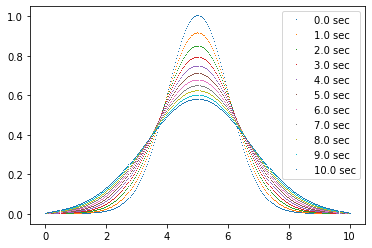

In [32]:
for time in np.linspace(0, 10, 11):
    n = int(time / (10/10000))
    plt.plot(xs, N[n, :], marker=',', ls='none', label=str(time)+' sec')
    plt.legend()

In [7]:
def squarebump(x):
    halfwidth = 1
    center = 5
    if np.abs(x-5) <= halfwidth: return 1
    else: return 0
squarebump = np.vectorize(squarebump)

In [8]:
N, ts, xs = solve_diffusion_eqn_1D([0, 10], 10000, [0, 10], 300, 0.1, squarebump, BC='dirichlet')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


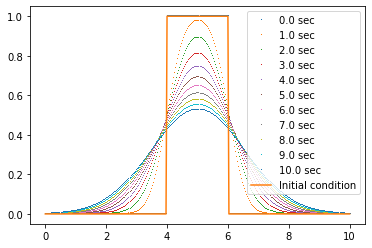

In [18]:
for time in np.linspace(0, 10, 11):
    n = int(time / (10/10000))
    plt.plot(xs, N[n, :], marker=',', ls='none', label=str(time)+' sec')
    
plt.plot(xs, N[0, :], label='Initial condition')
plt.legend()

In [21]:
def doublehump(x):
    return gaussian(x-2) + gaussian(x+2)

In [23]:
N, ts, xs = solve_diffusion_eqn_1D([0, 10], 10000, [0, 10], 300, 0.1, doublehump, BC='dirichlet')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


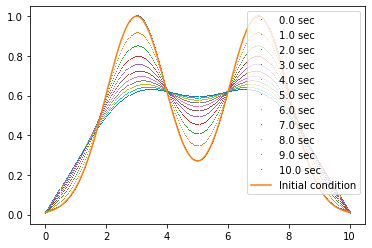

In [24]:
for time in np.linspace(0, 10, 11):
    n = int(time / (10/10000))
    plt.plot(xs, N[n, :], marker=',', ls='none', label=str(time)+' sec')
    
plt.plot(xs, N[0, :], label='Initial condition')
plt.legend()

# n-dimensional case

## Theory

We now return to the n-dimensional diffusion equation

$$
\frac{\partial}{\partial t} N(\vec{r}, t) = D \nabla^2 N(\vec{r}, t)
$$

where $\vec{r} = (x_1, \dots , x_n) \in \mathbb{R}^n$. This PDE will be solved on an n-dimensional rectangular prism $Q = [a_1, b_1] \times \dots \times [a_n, b_n] \subset \mathbb{R}^n$ over a time frame $[0, t_f]$. It will be solved with initial condition $N(\vec{r}, 0) = f(\vec{r}) \ (\forall \vec{r} \in Q)$ for some function $f: Q \rightarrow \mathbb{R}$, and with Dirichlet boundary conditions $N(\vec{r}, t) = 0 \ (\forall \vec{r} \in \partial Q, \ \forall t \in [0, t_f])$.

The diffusion equation can be written

$$
\frac{\partial}{\partial t} N(\vec{r}, t) = D \sum_{k=1}^n \frac{\partial^2}{\partial x_k^2} N(\vec{r}, t)
$$

. We discretize time into steps of $\Delta t$ and each spatial direction $x_1, \dots , x_n$ into steps of $\Delta x_1, \dots , \Delta x_n$, respectively. Analogously to the 1-D case, we can find that

$$
\frac{N_{i_1, \dots, i_n}^{j+1} - N_{i_1, \dots, i_n}^{j}}{\Delta t} = D \sum_{k=1}^n \left( \frac{N_{i_1, \dots, i_{k+1}, \dots i_n}^j - 2 N_{i_1, \dots i_n}^j + N_{i_1, \dots, i_{k-1}, \dots i_n}^j}{\Delta x_k^2} \right)
$$

, where upper indices represent time and the $n$ lower indices represent spatial position.

We can rearrange to find

$$
N_{i_1, \dots, i_n}^{j+1} = D \Delta t \sum_{k=1}^n \left( \frac{N_{i_1, \dots, i_{k+1}, \dots i_n}^j - 2 N_{i_1, \dots i_n}^j + N_{i_1, \dots, i_{k-1}, \dots i_n}^j}{\Delta x_k^2} \right) + N_{i_1, \dots, i_n}^{j}
$$

, which allows us to find N at the next time step from information about the current time.

## Solver code

In [579]:
def solve_diffusion_eqn(n, tspan, n_tsteps, xspan, n_xsteps, D, f, BC='dirichlet'):
    """
    Gives a numerical solution to the n-dimensional diffusion equation.
    *** Currently only works for the 2-dimensional case ***
    Should have dx << lambda and dt << (dx)^2 / D for accurate results, where lambda is the characteristic
        wavelength of the initial condition function.
    n: number of spatial dimensions
    tspan: [start_time, stop_time]
    n_tsteps: number of time steps to use
    xspan: A list of n entries, each of form [a_k, b_k]. The kth entry is the xspan for x_k.
    n_xsteps: A list of n integers. The kth entry is the number of spatial steps to use in the kth direction.
    D: diffusion constant
    f: function f mapping n variables (in a 1D numpy array) to a real number. Gives the initial condition N(r, 0) = f(r)
    BC: indicates boundary conditions to use. If 'dirichlet', uses fixed boundary conditions
        N(r, t) = 0 for all r on the boundary for all t
    return: A (n+1)-dimensional array with t on the 0th axis and x_k on kth axis that holds solved values for 
        N_{i_1, ..., i_n}^j. 
        Also returns ts, a 1-dimensional array which lists the times used for the grid,
        and xs, a list of 1-dimensional arrays, the kth of which lists the positions that were used in the kth spatial
        direction.
    """
    
    tspan = np.asarray(tspan, dtype=np.double)
    ts = np.linspace(tspan[0], tspan[1], n_tsteps+1, dtype=np.double)
    dt = (tspan[1] - tspan[0]) / n_tsteps
    
    xspan = np.asarray(xspan, dtype=np.double)
    n_xsteps = np.asarray(n_xsteps, dtype=np.int)
    xs = [np.linspace(xspan[k, 0], xspan[k, 1], n_xsteps[k]+1, dtype=np.double) for k in range(n)]
    dx = (xspan[:, 0] - xspan[:, 1]) / n_xsteps
    
    shape = tuple(np.append(n_tsteps+1, n_xsteps+1))
    N = np.zeros(shape, dtype=np.double) # 0th index = time, kth index = kth spatial direction
    
    
    ### THE FOLLOWING ONLY WORKS IN THE 2-D (n=2) CASE ###
    
    # Set initial conditions
    coords = np.array(np.meshgrid(xs[0], xs[1], indexing='ij'), dtype=np.double).T  # 'coords' is a 2D grid holding values of [x1, x2] in each cell
    N[0, :] = np.apply_along_axis(f, 2, coords).T  # Apply the function f to each [x1, x2]. Put the value of 
                                                   # f([x1, x2]) into the correct spot in the N array.
    
    # Solve
    if BC=='dirichlet':
        # Note: Dirichlet BCs are hard-coded in by essentially setting 
        # N[j, -1, i_2] = N[j, n_xsteps[0]+1, i_2] = 0 (for all j, for all i_2)
        # N[j, i_1, -1] = N[j, i_1, n_xsteps[1]+1] = 0
        for j in range(n_tsteps):
            for i1 in range(n_xsteps[0]+1):
                for i2 in range(n_xsteps[1]+1):
                    # Store values of cells that are adjacent in space (envision i1 as the horizontal direction,
                    # i2 as the vertical region). Also implements Dirichlet conditions.
                    zero = np.double(0)
                    left  = zero if i1==0           else N[j, i1-1, i2  ]
                    right = zero if i1==n_xsteps[0] else N[j, i1+1, i2  ]
                    up    = zero if i2==0           else N[j, i1  , i2-1]
                    down  = zero if i2==n_xsteps[1] else N[j, i1  , i2+1]
                    current = N[j, i1, i2]
                                        
                    N[j+1, i1, i2] = D*dt * ( (right - 2*current + left)/(dx[0]**2) + (up - 2*current + down)/(dx[1]**2) ) + current
            #debug
            if j % 10 == 0: print(j)
                
    elif BC=='neumann':
        for j in range(n_tsteps):
            for i1 in range(n_xsteps[0]+1):
                for i2 in range(n_xsteps[1]+1):
                    # Store values of cells that are adjacent in space (envision i1 as the horizontal direction,
                    # i2 as the vertical region). Also implements Neumann conditions by using "guard cells":
                    #  -1|0|1|2|3|
                    #   @|$|$|@|...
                    # where we force the @s and the $s to hold the same values.
                    zero = np.double(0)
                    left  = N[j, i1+2, i2  ] if i1==0           else N[j, i1-1, i2  ]
                    right = N[j, i1-2, i2  ] if i1==n_xsteps[0] else N[j, i1+1, i2  ]
                    up    = N[j, i1  , i2+2] if i2==0           else N[j, i1  , i2-1]
                    down  = N[j, i1  , i2-2] if i2==n_xsteps[1] else N[j, i1  , i2+1]
                    current = N[j, i1, i2]
                    
                    if i1!=0 and i1!=n_xsteps[0] and i2!=0 and i2!=n_xsteps[1]: # not on boundary                
                        N[j+1, i1, i2] = D*dt * ( (right - 2*current + left)/(dx[0]**2) + (up - 2*current + down)/(dx[1]**2) ) + current
                
            #fix edges
            for i1 in range(n_xsteps[0]-1):
                N[j+1, i1+1, 0] = N[j+1, i1+1, 1]
                N[j+1, i1+1, n_xsteps[1]] = N[j+1, i1+1, n_xsteps[1]-1]
            for i2 in range(n_xsteps[1]-1):
                N[j+1, 0, i2+1] = N[j+1, 1, i2+1]
                N[j+1, n_xsteps[0], i2+1] = N[j+1, n_xsteps[0]-1, i2+1]
            #fix corners
            N[j+1, 0          , 0          ] = 0.5 * (N[j+1, 1            , 0            ] + N[j+1, 0          , 1            ])
            N[j+1, n_xsteps[0], 0          ] = 0.5 * (N[j+1, n_xsteps[0]-1, 0            ] + N[j+1, n_xsteps[0], 1            ])
            N[j+1, 0          , n_xsteps[1]] = 0.5 * (N[j+1, 0            , n_xsteps[1]-1] + N[j+1, 1          , n_xsteps[1]  ])
            N[j+1, n_xsteps[0], n_xsteps[1]] = 0.5 * (N[j+1, n_xsteps[0]-1, n_xsteps[1]  ] + N[j+1, n_xsteps[0], n_xsteps[1]-1])
                
            
            #debug
            if j % 100 == 0: print(j)
            
    else:
        print('These boundary conditions have not been implemented yet')
        return
    
    return N, ts, xs

## Plotting code for 2-D case

In [473]:
def plt2D(grid, x1s, x2s):
    X, Y = np.meshgrid(x1s, x2s, indexing='ij')
    levels = np.linspace(0, 1, 101)
    plt.contourf(X,Y,grid, levels)
    plt.gca().set_aspect(1.0)
    plt.show()
    

In [506]:
def plt3D(grid, x1s, x2s):
    from mpl_toolkits import mplot3d
    X, Y = np.meshgrid(x1s, x2s, indexing='ij')
    ax = plt.axes(projection='3d')
    ax.contour3D(X, Y, grid, 50, cmap='viridis')
    ax.set_zlim3d(0, 1)
    plt.show()

## Applications (2-D case)

In [385]:
def two_D_gaussian(coords):
    # To be used as an initial condition
    a = 1
    sigma = 0.1
    mu_x = 0.5
    mu_y = 0.5
    
    x_dist = np.exp(-(coords[0] - mu_x)**2 / (2*sigma**2))
    y_dist = np.exp(-(coords[1] - mu_y)**2 / (2*sigma**2))
    
    return a * x_dist * y_dist

In [432]:
N, ts, xs = solve_diffusion_eqn(2, [0, 1], 10000, [[0,1],[0,1]], [100,100], 0.1, two_D_gaussian, BC='dirichlet')
# takes 15 min with 10000 time steps and 100 spatial steps in each direction

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [495]:
%matplotlib inline
# %matplotlib notebook

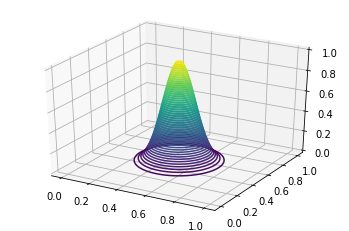

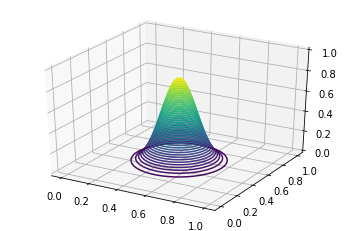

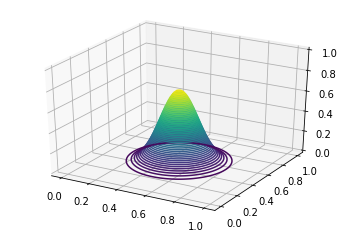

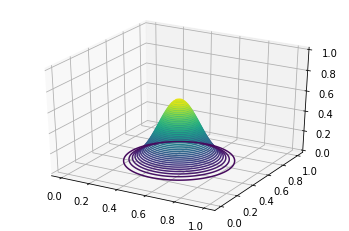

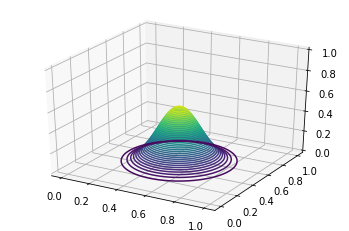

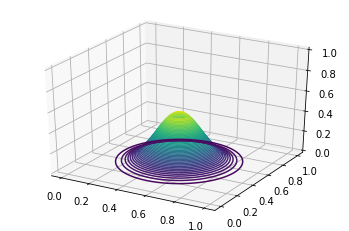

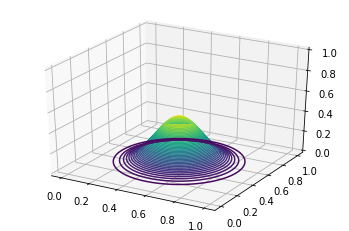

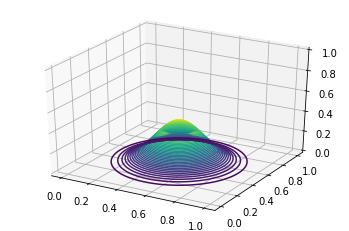

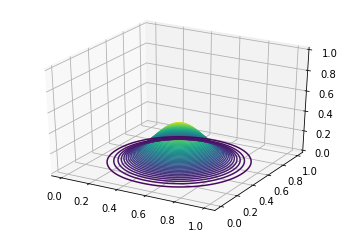

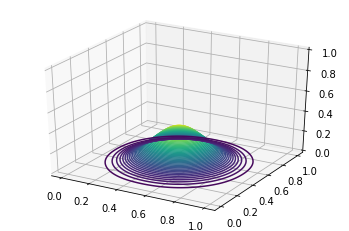

In [508]:
for i in range(10):
    plt3D(N[i*100], xs[0], xs[1])

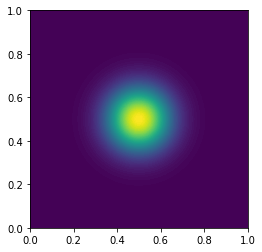

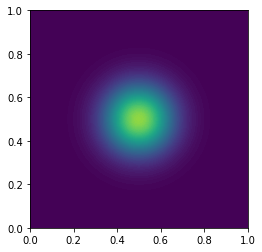

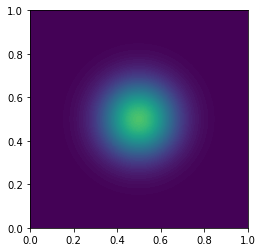

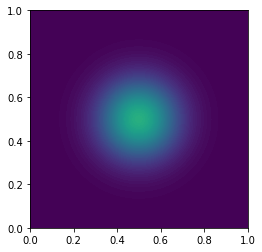

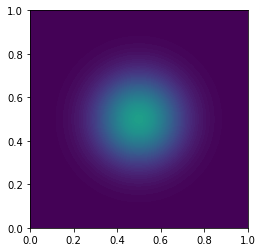

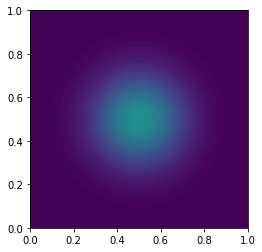

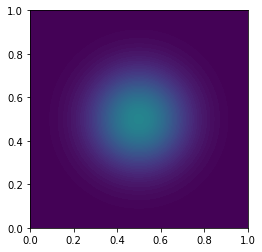

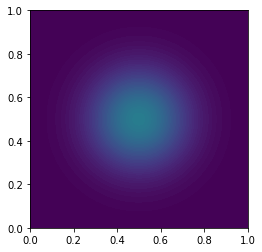

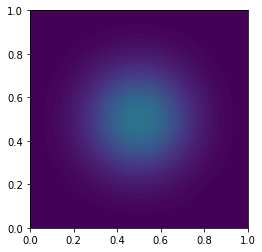

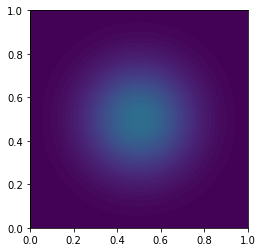

In [486]:
for i in range(10):
    plt2D(N[i*100], xs[0], xs[1])


In [513]:
def quadruple_two_D_gaussian(coords):
    x1 = coords[0]
    x2 = coords[1]
    return (  two_D_gaussian(np.array([x1+0.2, x2+0.2]))
            + two_D_gaussian(np.array([x1-0.2, x2+0.2]))
            + two_D_gaussian(np.array([x1+0.2, x2-0.2]))
            + two_D_gaussian(np.array([x1-0.2, x2-0.2])))

In [514]:
N, ts, xs = solve_diffusion_eqn(2, [0, 0.3], 3000, [[0,1],[0,1]], [100,100], 0.1, quadruple_two_D_gaussian, BC='dirichlet')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

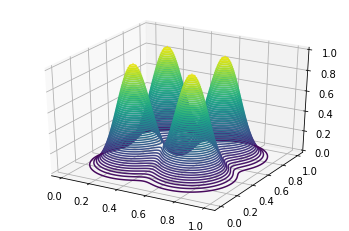

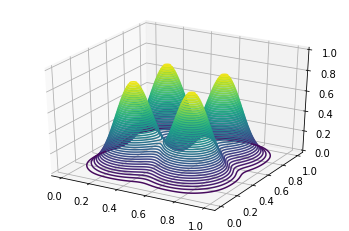

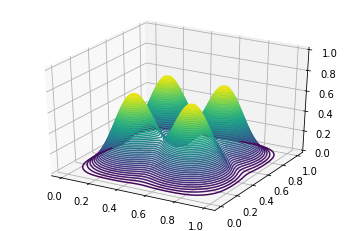

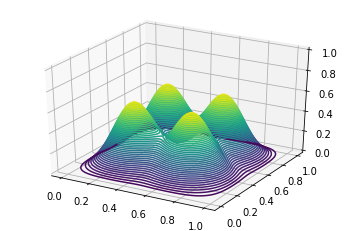

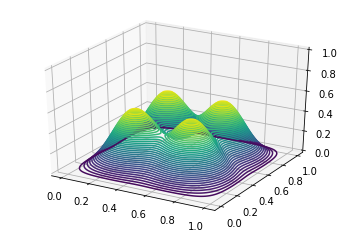

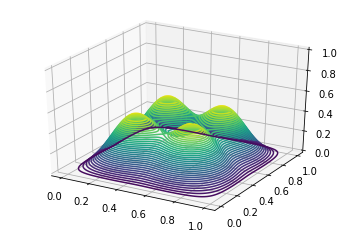

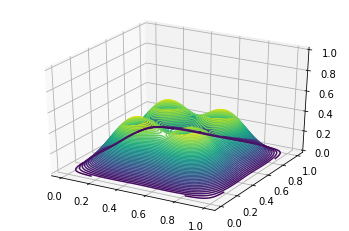

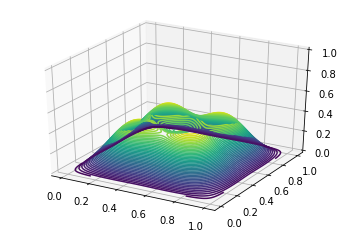

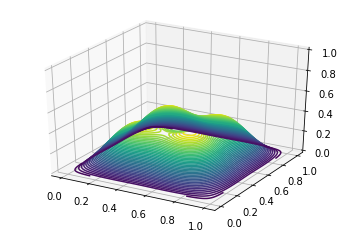

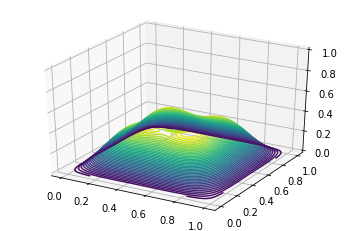

In [515]:
for i in range(10):
    plt3D(N[i*100], xs[0], xs[1])

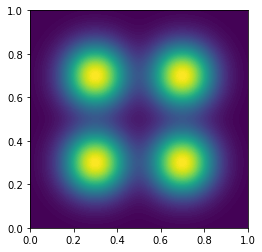

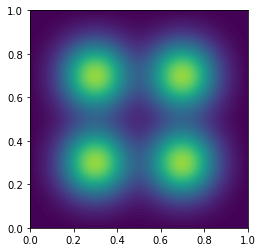

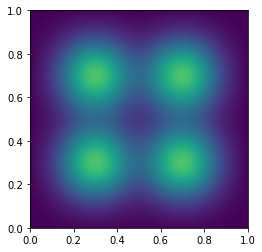

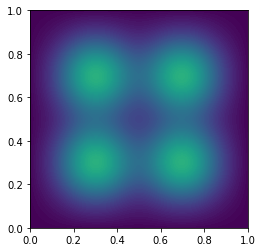

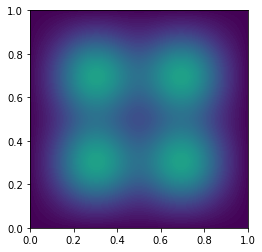

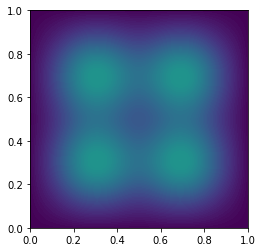

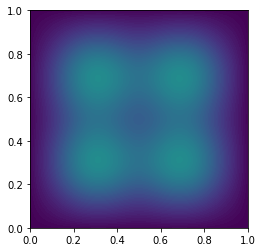

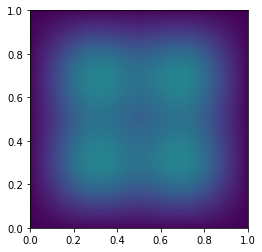

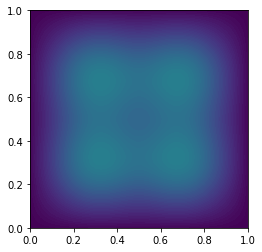

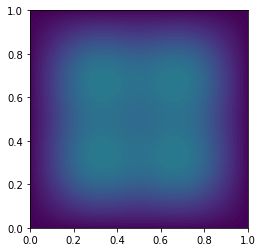

In [516]:
for i in range(10):
    plt2D(N[i*100], xs[0], xs[1])

In [520]:
N, ts, xs = solve_diffusion_eqn(2, [0, 1], 1000, [[0,1],[0,1]], [30,30], 0.1, two_D_gaussian, BC='neumann')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


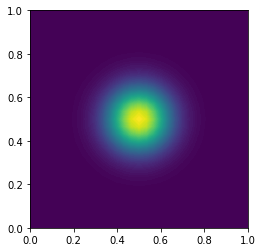

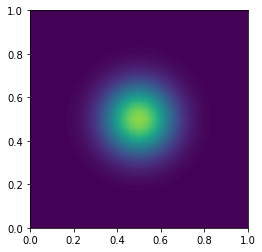

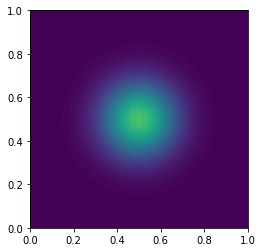

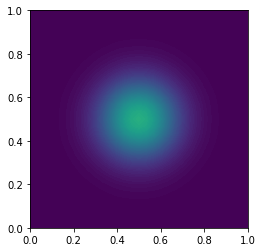

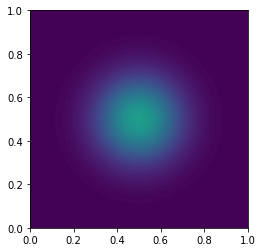

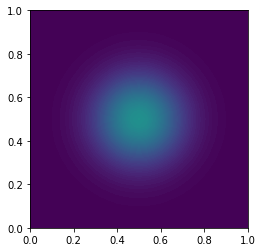

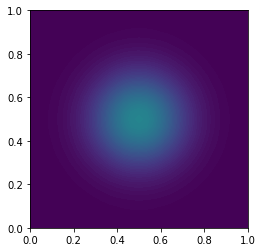

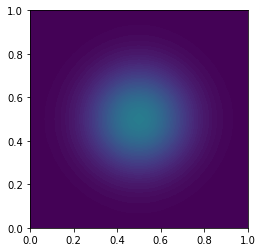

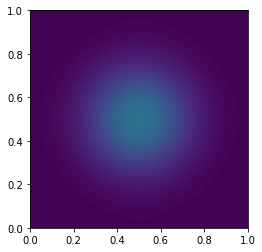

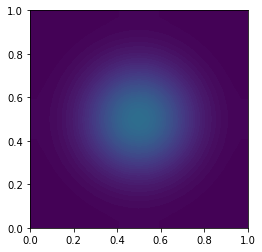

In [521]:
for i in range(10):
    plt2D(N[i*10], xs[0], xs[1])

In [606]:
def sigmoid_backwards(coords):
    # To be used as an initial condition
    a = 10
    return 1/(1+np.exp(a*coords[0]))

In [607]:
N, ts, xs = solve_diffusion_eqn(2, [0, 10], 1000, [[-1,1],[0,1]], [30,3], 0.1, sigmoid_backwards, BC='neumann')

0
100
200
300
400
500
600
700
800
900


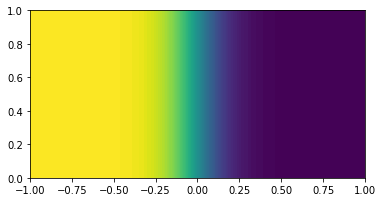

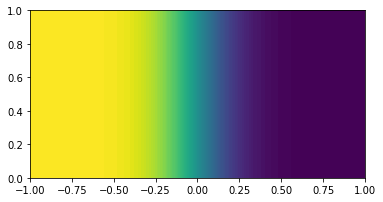

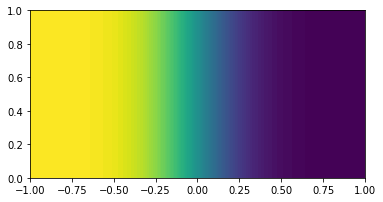

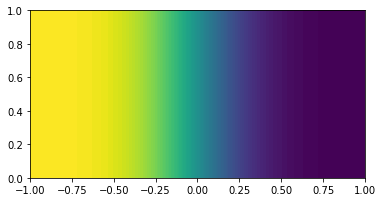

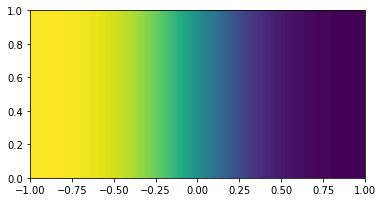

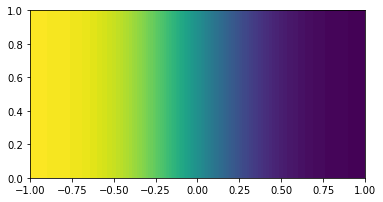

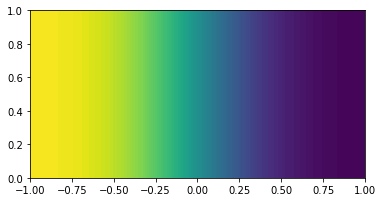

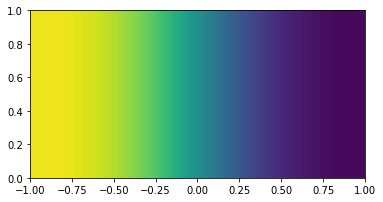

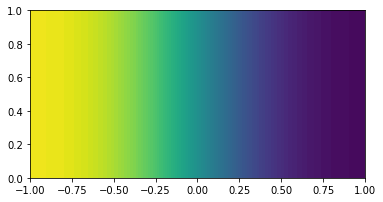

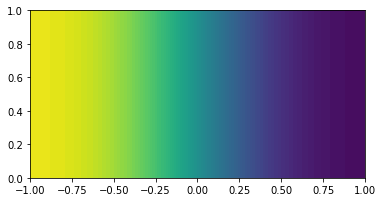

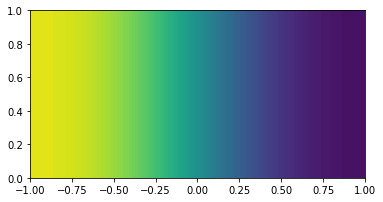

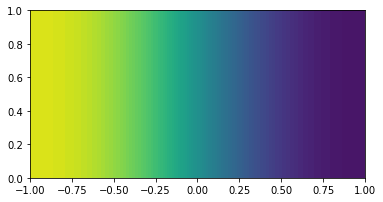

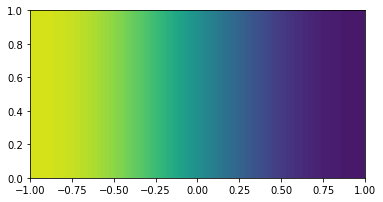

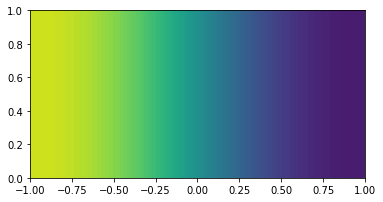

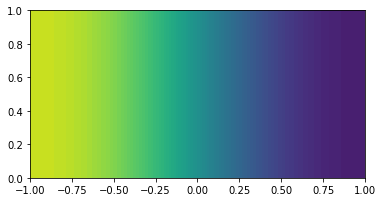

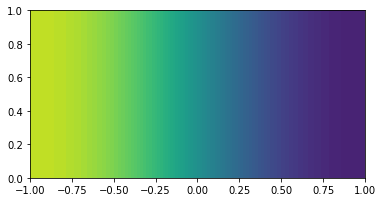

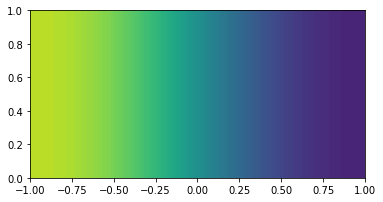

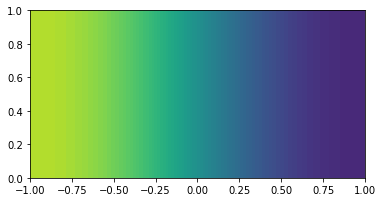

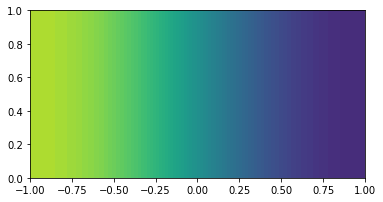

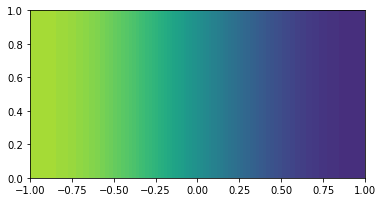

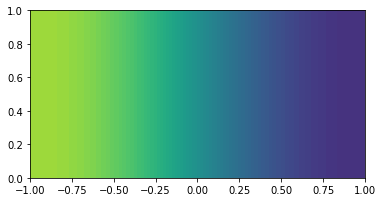

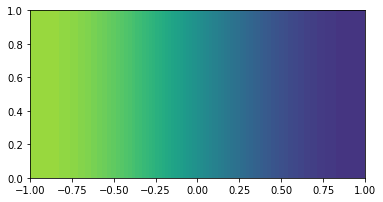

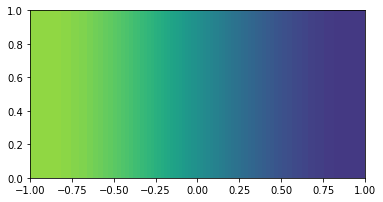

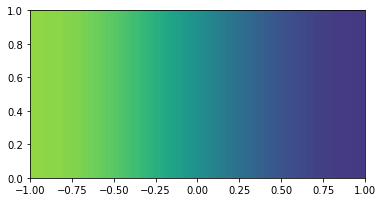

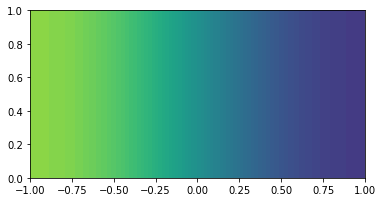

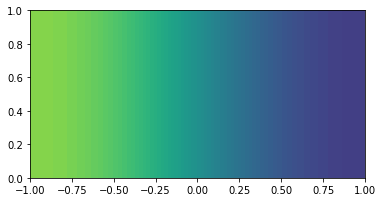

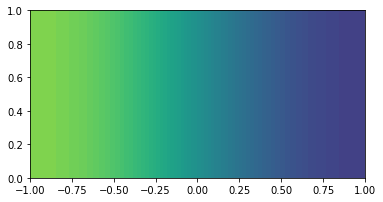

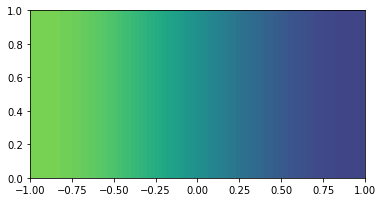

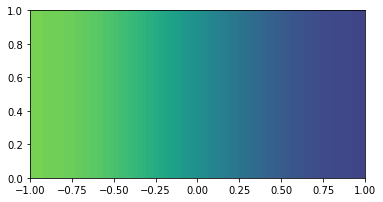

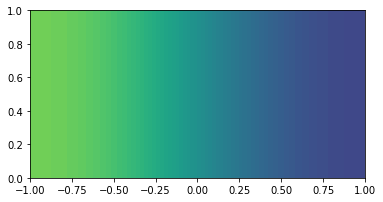

In [609]:
for i in range(30):
    plt2D(N[i*10], xs[0], xs[1])